In [1]:
import pandas as pd 
from StringIO import StringIO
import matplotlib.pyplot as plt
import numpy as np 
import textract
%matplotlib inline

In [4]:
army_df = pd.read_csv('../data/ARMY_court_martial_edited.csv', encoding='utf-8', index_col=0)

# Court-martials by rank

In [14]:
# https://www.statista.com/statistics/239383/total-military-personnel-of-the-us-army-by-grade/
t = """2016	2017*	2018*
General (O10)	12	11	11
Lieutenant General (O9)	47	45	45
Major General (O8)	139	135	124
Brigadier General (O7)	149	141	129
Colonel (O6)	4,386	4,202	4,152
Lieutenant Colonel (O5)	9,904	9,032	8,913
Major (O4)	16,835	15,354	14,902
Captain (O3)	30,679	28,992	28,870
1st Lieutenant (O2)	13,387	11,754	12,587
2nd Lieutenant (O1)	7,212	6,988	7,301
Warrant Officer (W5)	651	591	592
Warrant Officer (W4)	2,160	199	1,991
Warrant Officer (W3)	4,394	4,225	4,105
Warrant Officer (W2)	6,506	5,136	5,720
Warrant Officer (W1)	1,907	2,403	1,967
Sergeant Major (E9)	3,580	3,324	3,330
1st Sergeant/Master Sergeant (E8)	11,736	10,768	10,830
Platoon Sergeant (E7)	37,505	35,103	35,465
Staff Sergeant (E6)	58,500	53,924	56,648
Sergeant (E5)	71,140	66,465	70,335
Corporal/Specialist (E4)	122,980	111,891	100,707
Private 1st Class (E3)	46,305	47,462	50,386
Private-E2 (E2)	27,266	28,112	29,883
Private-E1 (E1)	18,630	19,500	50,578
Total Officer Personnel	98,368	91,008	91,409
Total Enlisted	397,642	376,549	378,162
Cadets	4,346	4,386	4,395
Total End Strength	500,356	471,943	473,966"""
rank_df = pd.read_csv(StringIO(t), sep='\t')

In [269]:
overall_counts_df = rank_df['2016'].apply(lambda x: x.replace(',','')).astype(float)

In [95]:
abbrev_mapping = pd.read_csv('../data/Ranks_Army.csv')

In [158]:
# get rough mapping, to be refined by hand
counts = army_df.Rank.value_counts().to_frame('count').reset_index()
counts['possible-names'] = np.nan
name_mapping = {}
for idx in range(len(counts)):
    name = counts.iloc[idx]['index']
    t = abbrev_mapping[abbrev_mapping['abbrev'].apply(lambda x: name in x)]['title'].values.tolist()
    name_mapping[name] = t if len(t) > 0 else name

In [124]:
master_mapping = {'1LT': '1st Lieutenant (O2)',
 u'1SG': '1st Sergeant/Master Sergeant (E8)',
 u'2LT': '2nd Lieutenant (O1)',
 u'CDT': 'Cadets',
 u'COL': 'Colonel (O6)',
 u'CPL': 'Corporal/Specialist (E4)',
 u'CPT': 'Captain (O3)',
 u'CSM': 'Sergeant Major (E9)',
 u'CW2': 'Warrant Officer (W2)',
 u'CW3': 'Warrant Officer (W3)',
 u'CW4': 'Warrant Officer (W4)',
 u'Captain': u'Captain (O3)',
 u'Chief Warrant Officer': 'Warrant Officer (W5)',
 u'First Lieutenant': '1st Lieutenant (O2)',
 u'LTC': 'Lieutenant Colonel (O5)',
 u'MAJ': 'Major (O4)',
 u'MSG': '1st Sergeant/Master Sergeant (E8)',
 u'Major': 'Major (O4)',
 u'PFC': 'Private 1st Class (E3)',
 u'PV1': 'Private-E1 (E1)',
 u'PV2': 'Private-E2 (E2)',
 u'PVT': 'Private-E1 (E1)',
 u'Private': 'Private-E1 (E1)',
 u'Private (E-1)': u'Private-E1 (E1)',
 u'Private First Class': 'Private 1st Class (E3)',
 u'SFC': '1st Sergeant/Master Sergeant (E8)',
 u'SGM': 'Sergeant Major (E9)',
 u'SGT': 'Sergeant (E5)',
 u'SPC': 'Corporal/Specialist (E4)',
 u'SSG': 'Staff Sergeant (E6)',
 u'Second Lieutenant': '2nd Lieutenant (O1)',
 u'Sergeant': 'Sergeant (E5)',
 u'Specialist': 'Corporal/Specialist (E4)',
 u'Staff Sergeant': 'Staff Sergeant (E6)',
 u'United States Military Academy Cadet': 'Cadets',
 u'WO1': 'Warrant Officer (W1)'}

In [162]:
master_mapping_df = pd.Series(master_mapping).to_frame('mapping_name')

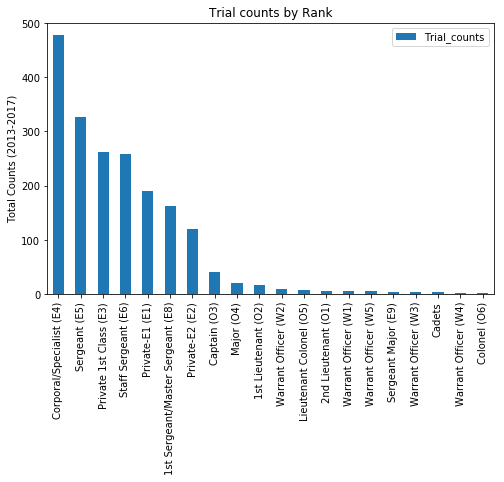

In [239]:
counts_df = counts[['index', 'count']].merge(master_mapping_df, how='left', left_on='index', right_index=True).groupby('mapping_name')['count'].sum()
(counts_df
 .sort_values(ascending=False)
 .to_frame('Trial_counts')
 .plot(kind='bar', figsize=(8,5))
)
plt.title('Trial counts by Rank')
plt.ylabel('Total Counts (2013-2017)')
plt.xlabel('');

In [270]:
overall_counts_df = overall_counts_df*4

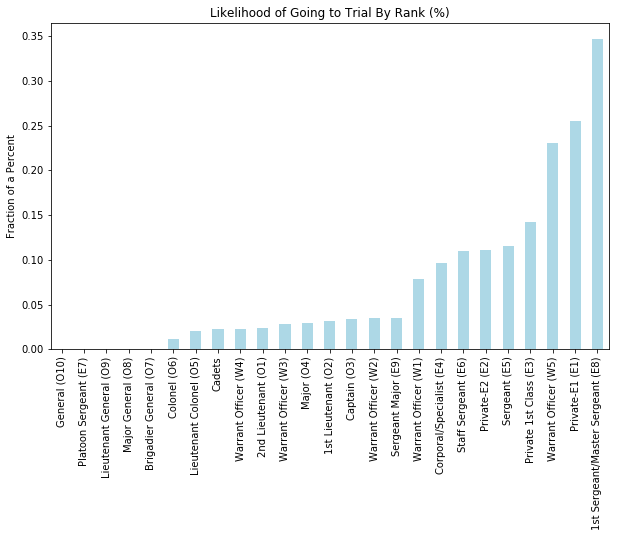

In [288]:
t = (counts_df
 .to_frame('counts')
 .merge(overall_counts_df.to_frame('overall_counts'), how='right', right_index=True, left_index=True)
 .pipe(lambda df: df['counts'] / df['overall_counts']) 
 * 100
).fillna(0).sort_values().drop(['Total Enlisted', 'Total Officer Personnel', 'Total End Strength'])
t.plot(kind='bar', color='lightblue', figsize=(10,6))
plt.ylabel('Fraction of a Percent')
plt.title('Likelihood of Going to Trial By Rank (%)')

In [232]:
by_conviction_counts = army_df.groupby('Rank')['Conclusion'].value_counts().to_frame('rank').reset_index()
by_conviction_counts_df = by_conviction_counts.merge(
    master_mapping_df,
    how='left',
    left_on='Rank',
    right_index=True
).groupby(['mapping_name', 'Conclusion']).sum()

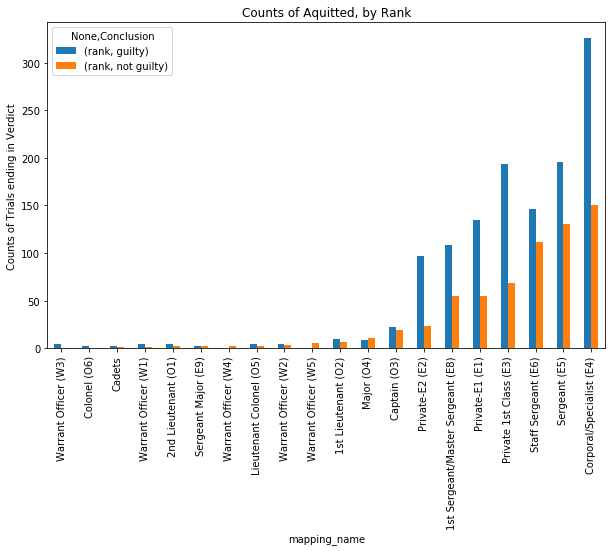

In [233]:
(by_conviction_counts_df
 .groupby(['mapping_name', 'Conclusion'])
 .sum().unstack()
 .fillna(0)
 .sort_values(('rank','not guilty'))
 .plot(kind='bar', figsize=(10,6))
)
plt.ylabel('Counts of Trials ending in Verdict')
plt.title('Counts of Aquitted, by Rank')

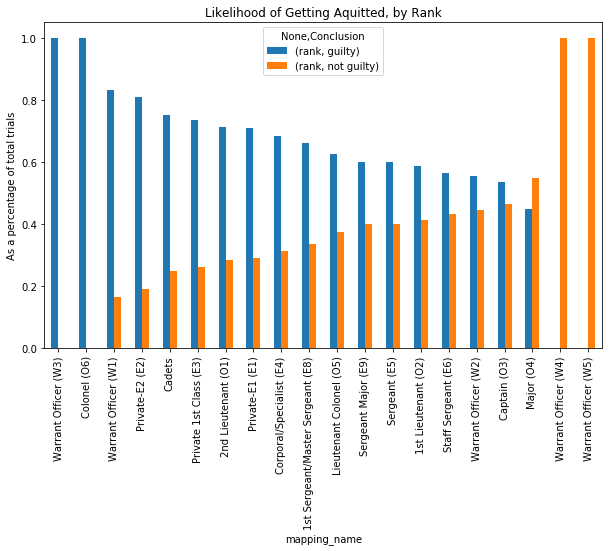

In [234]:
((by_conviction_counts_df / by_conviction_counts_df.reset_index().groupby('mapping_name').sum())
 .unstack()
 .sort_values(('rank','guilty'), ascending=False)
 .plot(kind='bar', figsize=(10,6))
)
plt.ylabel('As a percentage of total trials')
plt.title('Likelihood of Getting Aquitted, by Rank')